---
title: Informes Cambio de Componentes
subtitle: Revisión de completitud
author: Chief Reliability
date: 2023-01-23
---

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
from pathlib import Path


import pandas as pd
import polars as pl
import dagster as dg
from kdags.resources import *
from io import BytesIO
import pdfplumber
from datetime import datetime
import re
import os
from kdags.definitions import *
from kdags.readr import Readr
from kdags.resources.ggplot import *

import matplotlib.pyplot as plt
import numpy as np

context = dg.build_asset_context()

In [2]:
def clean_icc_data(df):

    # Ensure date columns are proper datetime

    df["changeout_date"] = pd.to_datetime(df["changeout_date"])

    df["report_date"] = pd.to_datetime(df["report_date"])

    # Mark missing reports
    df["has_report"] = ~df["report_date"].isna()

    # Create week column based on changeout_date
    df["week"] = df["changeout_date"].dt.strftime("%Y-W%W")

    return df


def generate_weekly_summary(df):
    """
    Generate weekly summary statistics from the cleaned ICC data.

    Parameters:
        df (pd.DataFrame): Cleaned dataframe from read_and_clean_icc_data function

    Returns:
        pd.DataFrame: Weekly summary with metrics on report availability
    """
    # If this is already the summary format (from sample data)
    if "total" in df.columns and "missing" in df.columns:
        weekly_summary = df.copy()
    else:
        # Weekly analysis of missing reports
        weekly_summary = (
            df.groupby("week")
            .agg(
                total=("changeout_date", "count"),
                missing=("has_report", lambda x: (~x).sum()),
            )
            .reset_index()
        )

    # Calculate percentages and available counts
    weekly_summary["missing_percentage"] = (
        weekly_summary["missing"] / weekly_summary["total"] * 100
    ).round(1)
    weekly_summary["available"] = weekly_summary["total"] - weekly_summary["missing"]

    # Sort by week to ensure chronological order
    weekly_summary = weekly_summary.sort_values("week")

    # Filter to weeks with at least one record
    weekly_summary = weekly_summary[weekly_summary["total"] > 0]

    return weekly_summary


def plot_icc_report(weekly_summary):
    """
    Create the ICC report visualization using GGPrism.

    Parameters:
        weekly_summary (pd.DataFrame): Weekly summary from generate_weekly_summary function

    Returns:
        tuple: (fig, ax) - Matplotlib figure and axis objects
    """
    # Create theme and figure
    theme = GGPrism()
    fig, ax = theme.create_figure(figsize=(12, 7))

    # Plot stacked bars
    x = np.arange(len(weekly_summary))
    ax.bar(
        x,
        weekly_summary["available"],
        width=0.85,
        color=theme.COLORS[0],
        label="Available",
        edgecolor="white",
        linewidth=0.8,
    )
    ax.bar(
        x,
        weekly_summary["missing"],
        width=0.85,
        bottom=weekly_summary["available"],
        color=theme.COLORS[4],
        label="Missing",
        edgecolor="white",
        linewidth=0.8,
    )

    # Add percentage labels with improved positioning
    for i, row in enumerate(weekly_summary.itertuples()):
        # Adjust vertical position based on total value to prevent overlap
        vertical_offset = 0.3  # Base offset

        # Add more space for higher bars to prevent label overlap
        if row.total >= 5:
            vertical_offset = 0.4

        if row.missing > 0:
            ax.text(
                i,
                row.total + vertical_offset,
                f"{int(row.missing_percentage)}%",
                ha="center",
                va="bottom",
                fontsize=13,
                fontweight="bold",
                color=theme.FIXED_COLORS["axis_color"],
            )
        else:
            ax.text(
                i,
                row.total + vertical_offset,
                "0%",
                ha="center",
                va="bottom",
                fontsize=13,
                fontweight="bold",
                color=theme.FIXED_COLORS["axis_color"],
            )

    # Set x-ticks
    ax.set_xticks(x)
    ax.set_xticklabels(weekly_summary["week"], rotation=90)

    # Ensure y-axis has enough room for labels
    y_max = max(weekly_summary["total"]) + 1.5  # Add extra space for labels
    ax.set_ylim(0, y_max)

    # Apply styling and finalize plot
    theme.style_legend(ax, title="Report Status", loc="upper right")
    theme.finalize_plot(
        fig,
        ax,
        title="Weekly ICC Reports Status",
        xlabel="Week",
        ylabel="Number of Reports",
    )

    # Save the plot
    theme.save_plot(fig, "icc_report_plot.png")

    return fig, ax

In [3]:
icc_df = Readr.Maintenance.read_icc(context).to_pandas()

(<Figure size 1200x700 with 1 Axes>,
 <Axes: title={'center': 'Weekly ICC Reports Status'}, xlabel='Week', ylabel='Number of Reports'>)

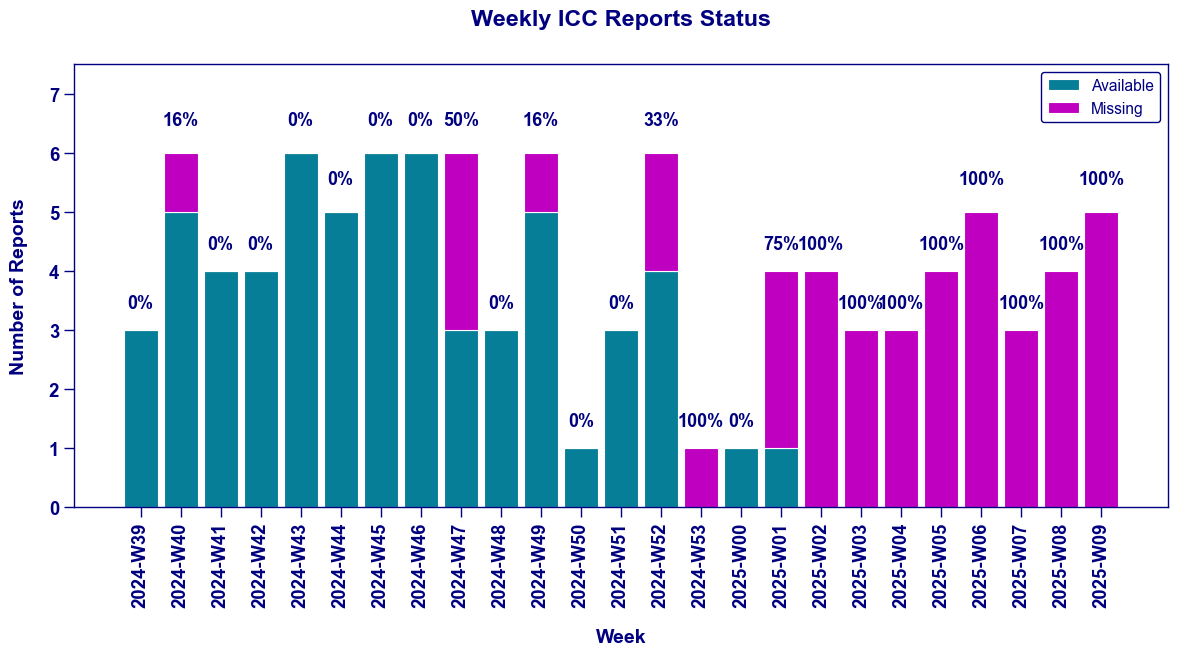

In [4]:
df = clean_icc_data(icc_df)
weekly_summary = generate_weekly_summary(df)
plot_icc_report(weekly_summary)

NameError: name 'GGPrism' is not defined

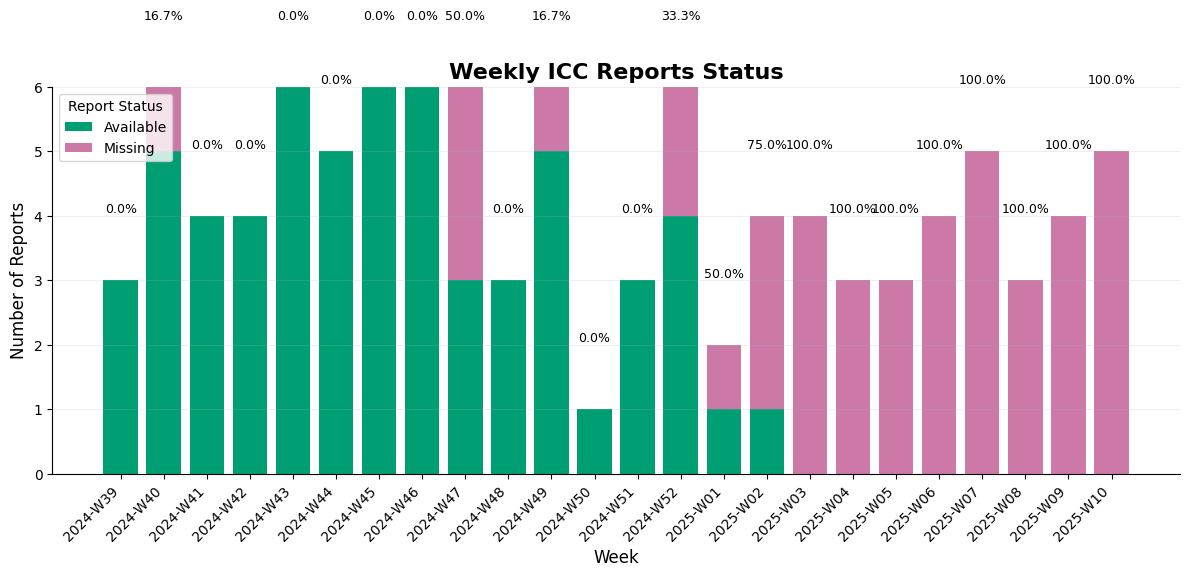

In [17]:
# Mark missing reports
df["has_report"] = ~df["report_date"].isna()

# Create week column based on changeout_date
df["week"] = df["changeout_date"].dt.isocalendar().week
df["year"] = df["changeout_date"].dt.isocalendar().year
df["yearweek"] = df["year"].astype(str) + "-W" + df["week"].astype(str).str.zfill(2)

# Weekly analysis of missing reports
weekly_summary = (
    df.groupby("yearweek")
    .agg(
        total=("equipment_name", "count"), missing=("has_report", lambda x: (~x).sum())
    )
    .reset_index()
)
weekly_summary["missing_percentage"] = (
    weekly_summary["missing"] / weekly_summary["total"] * 100
).round(1)
weekly_summary["available"] = weekly_summary["total"] - weekly_summary["missing"]

# Sort by yearweek to ensure chronological order
weekly_summary = weekly_summary.sort_values("yearweek")

# Use winter_bright colors
available_color = "#009E73"  # Green
missing_color = "#CC79A7"  # Purple

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create the stacked bars
weeks = range(len(weekly_summary))
week_labels = weekly_summary["yearweek"]
available = weekly_summary["available"]
missing = weekly_summary["missing"]

# Plot the stacked bars
ax.bar(weeks, available, label="Available", color=available_color)
ax.bar(weeks, missing, bottom=available, label="Missing", color=missing_color)

# Add percentage labels
for i, (total, missing_pct) in enumerate(
    zip(weekly_summary["total"], weekly_summary["missing_percentage"])
):
    ax.text(i, total + 1, f"{missing_pct}%", ha="center", va="bottom", fontsize=9)

# Set the x-ticks and labels
ax.set_xticks(weeks)
ax.set_xticklabels(week_labels, rotation=45, ha="right")

# Add titles and labels
ax.set_title("Weekly ICC Reports Status", fontsize=16, fontweight="bold")
ax.set_xlabel("Week", fontsize=12)
ax.set_ylabel("Number of Reports", fontsize=12)

# Add legend
ax.legend(title="Report Status", loc="upper left")

# Set background color to white and add grid lines only for y-axis
ax.set_facecolor("white")
ax.grid(axis="y", linestyle="-", alpha=0.2)

# Remove top and right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

plt.show()

In [14]:
plot_data

,yearweek,week_num,total,report_status,count
0,2024-W39,1,3,missing,0
1,2024-W40,2,6,missing,1
2,2024-W41,3,4,missing,0
3,2024-W42,4,4,missing,0
4,2024-W43,5,6,missing,0
5,2024-W44,6,5,missing,0
6,2024-W45,7,6,missing,0
7,2024-W46,8,6,missing,0
8,2024-W47,9,6,missing,3
9,2024-W48,10,3,missing,0


In [11]:
weekly_summary

,yearweek,total,missing,missing_percentage
0,2024-39,3,0,0.0
1,2024-40,6,1,16.7
2,2024-41,4,0,0.0
3,2024-42,4,0,0.0
4,2024-43,6,0,0.0
5,2024-44,5,0,0.0
6,2024-45,6,0,0.0
7,2024-46,6,0,0.0
8,2024-47,6,3,50.0
9,2024-48,3,0,0.0


asdasdasds